In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

rcParams = {
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 3,
    'axes.linewidth': 1,
    'font.family': 'san-serif',
    'text.usetex': True,
    'grid.linewidth': 0.5 
}

sns.set_context("paper", font_scale=1.5, rc=rcParams)

In [24]:
def print_error_lineplot(df):
    rcParams = {
        'xtick.labelsize': 12,
        'axes.titlesize': 28,
        'axes.labelsize': 18,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 12,
        'lines.linewidth': 2
    }
    sns.set_context("paper", font_scale=2, rc=rcParams)

    distributions = df['distribution'].unique()
    variables = sorted(df['n_variables'].unique())

    color_blues = sns.color_palette('Blues', len(variables)+3)[3:]
    color_reds = sns.color_palette('Reds', len(variables)+3)[3:]

    # Create a GridSpec with 2 rows and 2 columns
    fig_width = len(distributions)*5.0 + 3
    fig_height = 6.0
    fig, axes = plt.subplots(1, len(distributions), figsize=(fig_width, fig_height), sharex=True)
    
    for ax, distribution in zip(axes, distributions):
        df_dist = df[df['distribution'] == distribution]
        
        # Plotting the data
        sns.lineplot(
            data=df_dist, x='n_samples', y='gc_error', hue='n_variables',
            hue_order=variables, palette=color_blues, ax=ax)
        sns.lineplot(
            data=df_dist, x='n_samples', y='knn_error', hue='n_variables',
            hue_order=variables, palette=color_reds, ax=ax)

        ax.set_xscale('log')
        ax.set_ylabel('Error')
        ax.set_xlabel('Number of samples')
        ax.set_title(distribution)
        ax.get_legend().remove()
        ax.set_xlim(df_dist['n_samples'].min(),df_dist['n_samples'].max())
        ax.set_ylim(0,None)
        ax.grid(True)

    # Customizing legend
    gc_handles = [
        Line2D([0], [0], color=color_blues[i], lw=2, label=n_variables)
        for i, n_variables in enumerate(variables)
    ]
    ksg_handles = [
        Line2D([0], [0], color=color_reds[i], lw=2, label=n_variables)
        for i, n_variables in enumerate(variables)
    ]

    ax = axes[-1]
    ax.add_artist(ax.legend(handles=gc_handles, title='GC', loc='upper left', bbox_to_anchor=(1.02, 1.0)))
    ax.legend(handles=ksg_handles, title='KSG', loc='upper left', bbox_to_anchor=(1.02, 0.45))

    plt.tight_layout()
    plt.savefig('./figures/estimators/errors.pdf', format='pdf')
    plt.show()

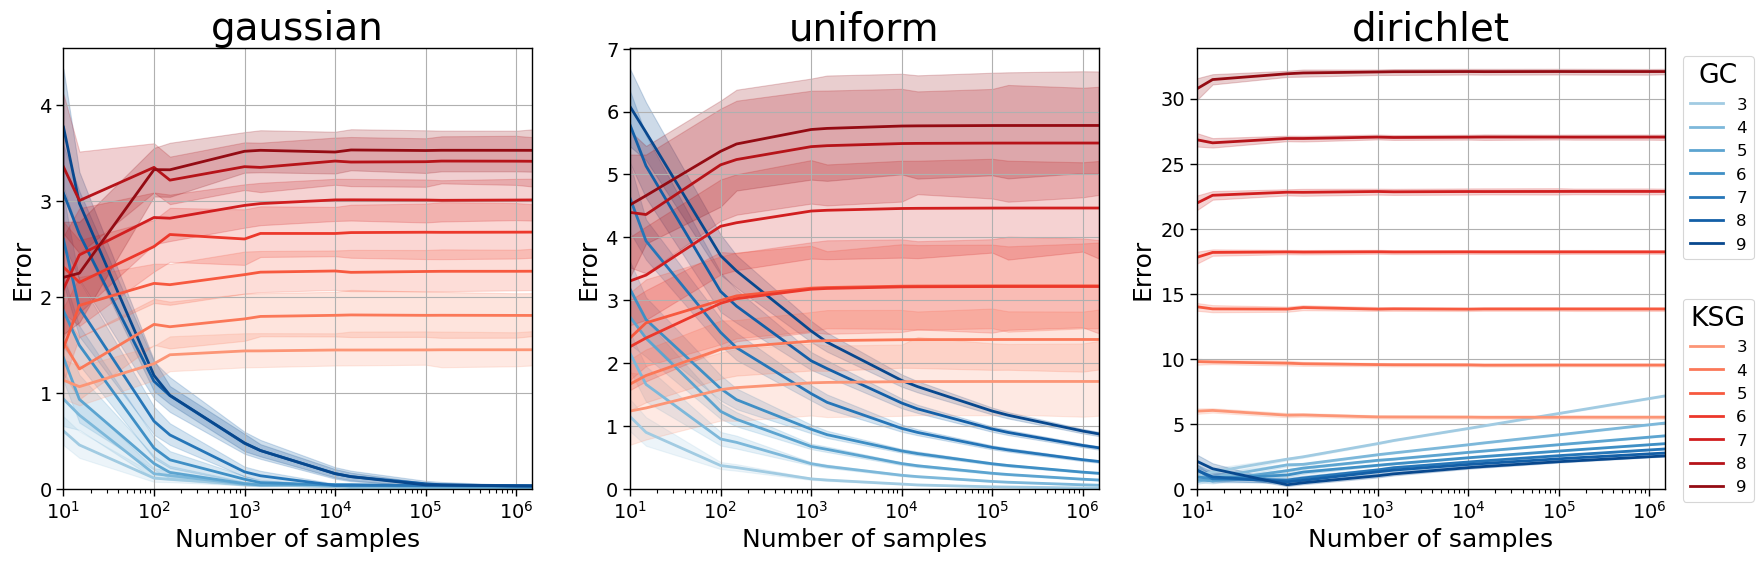

In [25]:
df1 = pd.read_csv(f'../benchmarking/results/estimators/distribution-gaussian_repeat-20.tsv', sep='\t')
df1['distribution'] = 'gaussian'
df2 = pd.read_csv(f'../benchmarking/results/estimators/distribution-uniform_repeat-20.tsv', sep='\t')
df2['distribution'] = 'uniform'
df3 = pd.read_csv(f'../benchmarking/results/estimators/distribution-dirichlet_repeat-20.tsv', sep='\t')
df3['distribution'] = 'dirichlet'

df = pd.concat([df1,df2,df3])

df['gc_error'] = abs(df['real_entropy'] - df['gcmi_entropy'])
df['knn_error'] = abs(df['real_entropy'] - df['npeet_entropy'])

print_error_lineplot(df)